In [3]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.optimizers as optimizers

import sys
sys.path.append("..")

from models.regression_model import DemoRegressionDGP
from likelihoods import Gaussian
from utils_training_demo import MCEM_demo, MCEM_windows_demo, MCEM_sampler_demo, MCEM_Q_maximizer_demo

from matplotlib import pyplot as plt

In [2]:
import pods
def get_mcycle_data(num_testing=100):
    data = pods.datasets.mcycle()
    X_train = data['X']
    m = np.sqrt(X_train.var())
    s = X_train.mean()
    X_train = (X_train - m)/s
    y = data['Y']
    scale=np.sqrt(y.var())
    offset=y.mean()
    Y_train = (y - offset)/scale

    X_test = np.linspace(-20., 80., num_testing)[:, None]
    X_test = (X_test - m)/s
    Y_test = np.zeros_like(X_test) #for compatibility
    # print(f"training size is {X_train.shape[0]}")
    return np.float32(X_train), np.float32(Y_train), np.float32(X_test), np.float32(Y_test)

def load_demo_data(num_testing):
    X_train, Y_train, X_test, Y_test = get_mcycle_data(num_testing)
    ds_X_train = tf.data.Dataset.from_tensor_slices(X_train)
    ds_Y_train = tf.data.Dataset.from_tensor_slices(Y_train)
    ds_train = tf.data.Dataset.zip((ds_X_train, ds_Y_train))
    ds_X_test = tf.data.Dataset.from_tensor_slices(X_test)
    ds_Y_test = tf.data.Dataset.from_tensor_slices(Y_test)
    ds_test = tf.data.Dataset.zip((ds_X_test, ds_Y_test))

    ds_train = ds_train.shuffle(94)
    # ds_test = ds_test.shuffle(num_testing)
    ds_train = ds_train.batch(47) # not using full data as one batch
    ds_test = ds_test.batch(num_testing)
    return ds_train, ds_test, X_test

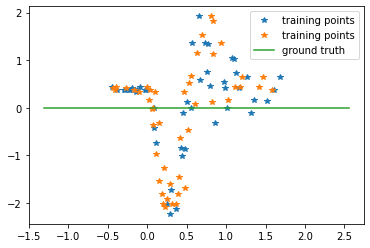

In [4]:
num_testing = 100
num_training = 94
ds_train, ds_test, X_test = load_demo_data(num_testing)
for x, y in ds_train:
    plt.plot(x[:,0], y[:,0], '*',linewidth=0.5, label='training points')
for x, y in ds_test:
    plt.plot(x[:,0], y[:,0], label='ground truth')
plt.legend()

# 1-layer GPs (free kernel params， using MCEM)

In [5]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=1, n_rf=100, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=True),
                          kernel_type_list=['RBF'], kernel_trainable=True,
                          random_fixed=True, input_cat=False)

In [6]:
model.Omega_hyperparams # as list

2022-08-25 08:07:50.483757: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [7]:
# EM sampler settings
lr_mcmc_0 = 0.01
batch_size = 47
sampler_EM = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                               lr_0=lr_mcmc_0, momentum_decay=0.99, resample_in_cycle_head=False,
                               start_sampling_epoch=1000, epochs_per_cycle=50)

# Maximizer setttings
lr_maximizer = 0.01
optimizer = optimizers.Adam(learning_rate=lr_maximizer)
maximizer = MCEM_Q_maximizer_demo(model, num_training, optimizer)

# sampler settings after fixing hyper-params
lr_fixing_hyper_0 = 0.01
sampler_fixing_hyper = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                                         lr_0=lr_fixing_hyper_0, momentum_decay=0.99, resample_in_cycle_head=False,
                                         start_sampling_epoch=2000, epochs_per_cycle=100)

In [8]:
# MCEM settings and training
total_EM_steps = 50
_, _, lines, W = MCEM_demo(sampler_EM, maximizer, sampler_fixing_hyper, total_EM_steps, ds_train, 
                      num_samples_EM=10, num_samples_fixing_hyper=100,
                      print_epoch_cycle_EM=50, print_epoch_cycle_fixing=100)

############### EM step 1 of total 50 steps. E Step:  ###############


2022-08-25 08:08:07.985973: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-25 08:08:08.567999: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-25 08:08:08.568062: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Sampling Epoch: 49
Mean Log Likelihood -- train: -37.514095306396484, -- test: -269.52252197265625 
Root Mean Squared Error -- train: 0.8820174336433411, -- test: 2.327686309814453 

Sampling Epoch: 99
Mean Log Likelihood -- train: -53.78580093383789, -- test: -345.5919494628906 
Root Mean Squared Error -- train: 1.050423264503479, -- test: 2.6342954635620117 

Sampling Epoch: 149
Mean Log Likelihood -- train: -86.47693634033203, -- test: -194.93682861328125 
Root Mean Squared Error -- train: 1.3255985975265503, -- test: 1.9815171957015991 

Sampling Epoch: 199
Mean Log Likelihood -- train: -55.35824203491211, -- test: -113.55960845947266 
Root Mean Squared Error -- train: 1.0652875900268555, -- test: 1.5162009000778198 

Sampling Epoch: 249
Mean Log Likelihood -- train: -35.612449645996094, -- test: -222.4581298828125 
Root Mean Squared Error -- train: 0.8601871132850647, -- test: 2.1158533096313477 

Sampling Epoch: 299
Mean Log Likelihood -- train: -30.659217834472656, -- test: -201

KeyboardInterrupt: 

In [8]:
model.Omega_hyperparams

[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.27986756>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.28996453], dtype=float32)>]

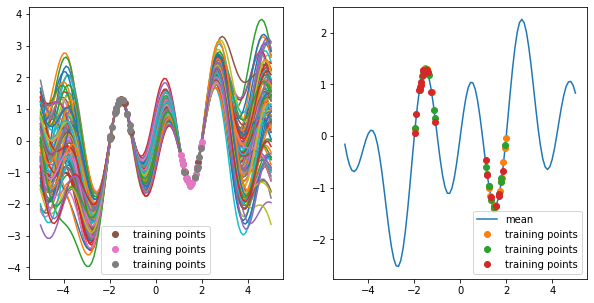

In [9]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[5:]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[5:]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy(), label='mean')
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()
# fig.savefig('1layer-sin-2.png')

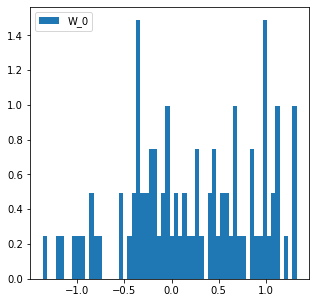

In [10]:
print_index = (25,0)
fig, ax = plt.subplots(1, model.n_hidden_layers, figsize=(model.n_hidden_layers*5,5))
for i in range(model.n_hidden_layers):
    W_print = []
    for W_model in W['W_'+str(i)][10:]:
        W_print.append(W_model[print_index])
    ax.hist(W_print, bins=60, density=True, label='W_'+str(i))
    ax.legend()
# fig.savefig('2w-sin-2.png')

# 1-layer DGPs (MCEM with Moving Windows)

In [11]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=1, n_rf=100, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=True),
                          kernel_type_list=['RBF'], kernel_trainable=True,
                          random_fixed=True, input_cat=False)

In [12]:
model.Omega_hyperparams

[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [13]:
# EM sampler settings
lr_mcmc_0 = 0.01
sampler_EM = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                               lr_0=lr_mcmc_0, momentum_decay=0.9, resample_in_cycle_head=False,
                               start_sampling_epoch=0, epochs_per_cycle=50)

# Maximizer setttings
lr_maximizer = 0.01
optimizer = optimizers.Adam(learning_rate=lr_maximizer)
maximizer = MCEM_Q_maximizer_demo(model, num_training, optimizer)

# sampler settings after fixing hyper-params
lr_fixing_hyper_0 = 0.01
sampler_fixing_hyper = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                                         lr_0=lr_fixing_hyper_0, momentum_decay=0.9, resample_in_cycle_head=False,
                                         start_sampling_epoch=0, epochs_per_cycle=100)

In [14]:
# MCEM with Moving Windows settings and training
total_EM_steps = 50
_, _, lines, W = MCEM_windows_demo(sampler_EM, maximizer, sampler_fixing_hyper, total_EM_steps, ds_train, window_size=10,
                             print_epoch_cycle_EM=50, print_epoch_cycle_fixing=100)

############### EM step 1 of total 50 steps. E Step:  ###############
#################### Sample No.1 at Epoch 49  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 49
Mean Log Likelihood -- train: -3.765904664993286, -- test: -88.61419677734375 
Root Mean Squared Error -- train: 0.3209221363067627, -- test: 1.3416247367858887 

#################### Sample No.2 at Epoch 99  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 99
Mean Log Likelihood -- train: -3.590348720550537, -- test: -116.5424575805664 
Root Mean Squared Error -- train: 0.31540435552597046, -- test: 1.5357481241226196 

#################### Sample No.3 at Epoch 149  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 149
Mean Log Likelihood -- train: -3.546091318130493, -- test: -103.41983032226562 
Root Mean Squared Error -- train: 0.3139980137348175, -- test: 1.447780966758728 

#################### Sample No.4 at Epoch 199  lr = 1.2021529605110715e-10 ####################


In [15]:
model.Omega_hyperparams

[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.15686728>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.3210245], dtype=float32)>]

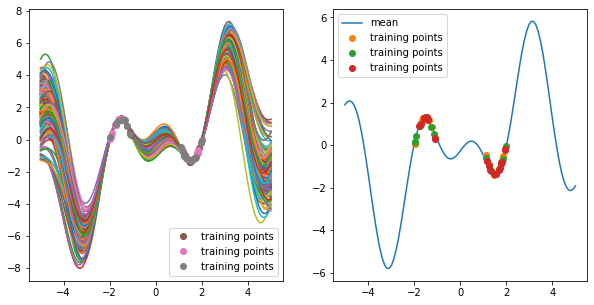

In [16]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[5:]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[5:]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy(), label='mean')
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()
# fig.savefig('1layer-sin-2.png')

# 2-layer DGPs (MCEM)

In [5]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=2, n_rf=100, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=True),
                          kernel_type_list=['RBF' for i in range(2)], kernel_trainable=True,
                          random_fixed=True, input_cat=False)

In [6]:
model.Omega_hyperparams

2022-08-25 08:10:39.095822: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [9]:
# EM sampler settings
batch_size = 47
lr_mcmc_0 = 0.01
sampler_EM = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                               lr_0=lr_mcmc_0, momentum_decay=0.95, resample_in_cycle_head=False,
                               start_sampling_epoch=500, epochs_per_cycle=50)

# Maximizer setttings
lr_maximizer = 0.01
optimizer = optimizers.Adam(learning_rate=lr_maximizer)
maximizer = MCEM_Q_maximizer_demo(model, num_training, optimizer)

# sampler settings after fixing hyper-params
lr_fixing_hyper_0 = 0.01
sampler_fixing_hyper = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                                         lr_0=lr_fixing_hyper_0, momentum_decay=0.95, resample_in_cycle_head=False,
                                         start_sampling_epoch=1000, epochs_per_cycle=50)

In [11]:
# MCEM settings and training
total_EM_steps = 100
_, _, lines, W = MCEM_demo(sampler_EM, maximizer, sampler_fixing_hyper, total_EM_steps, ds_train, 
                      num_samples_EM=10, num_samples_fixing_hyper=100,
                      print_epoch_cycle_EM=100, print_epoch_cycle_fixing=100)

############### EM step 1 of total 100 steps. E Step:  ###############


2022-08-25 08:12:22.810072: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-25 08:12:23.400432: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-25 08:12:23.400489: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Sampling Epoch: 99
Mean Log Likelihood -- train: -7.072976589202881, -- test: -24.773157119750977 
Root Mean Squared Error -- train: 0.41125717759132385, -- test: 0.7232814431190491 

Sampling Epoch: 199
Mean Log Likelihood -- train: -7.10526704788208, -- test: -27.11935806274414 
Root Mean Squared Error -- train: 0.4120416045188904, -- test: 0.755023181438446 

Sampling Epoch: 299
Mean Log Likelihood -- train: -7.369865417480469, -- test: -20.421611785888672 
Root Mean Squared Error -- train: 0.418413907289505, -- test: 0.6603825688362122 

Sampling Epoch: 399
Mean Log Likelihood -- train: -7.205226898193359, -- test: -22.394174575805664 
Root Mean Squared Error -- train: 0.4144604802131653, -- test: 0.6896059513092041 

Sampling Epoch: 499
Mean Log Likelihood -- train: -7.057804107666016, -- test: -26.62289810180664 
Root Mean Squared Error -- train: 0.41088807582855225, -- test: 0.748418927192688 

#################### Sample No.1 at Epoch 549  lr = 6.087738091409278e-10 ###########

2022-08-25 08:14:55.685991: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


#################### Sample No.5 at Epoch 749  lr = 6.087738091409278e-10 ####################
#################### Sample No.6 at Epoch 799  lr = 6.087738091409278e-10 ####################
Sampling Epoch: 799
Mean Log Likelihood -- train: -6.538516998291016, -- test: -27.928333282470703 
Root Mean Squared Error -- train: 0.41116055846214294, -- test: 0.7921474575996399 

#################### Sample No.7 at Epoch 849  lr = 6.087738091409278e-10 ####################
#################### Sample No.8 at Epoch 899  lr = 6.087738091409278e-10 ####################
Sampling Epoch: 899
Mean Log Likelihood -- train: -6.44998025894165, -- test: -27.65966033935547 
Root Mean Squared Error -- train: 0.4088464379310608, -- test: 0.788504421710968 

#################### Sample No.9 at Epoch 949  lr = 6.087738091409278e-10 ####################
#################### Sample No.10 at Epoch 999  lr = 6.087738091409278e-10 ####################
Sampling Epoch: 999
Mean Log Likelihood -- train: -6.5189428329

In [12]:
model.Omega_hyperparams

[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.051458575>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.06790732], dtype=float32)>,
 <tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.01360142>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.05142293], dtype=float32)>]

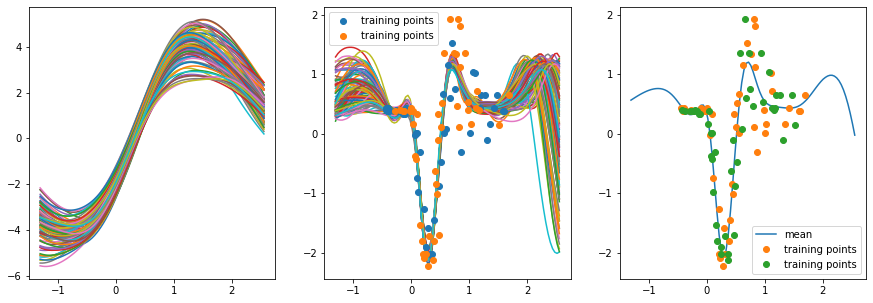

In [14]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[:]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[:]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy(), label='mean')
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()
# fig.savefig('2layer-sin.png')

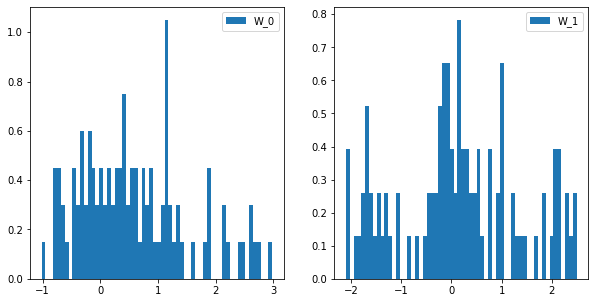

In [15]:
print_index = (25,0)
fig, ax = plt.subplots(1, model.n_hidden_layers, figsize=(model.n_hidden_layers*5,5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    W_print = []
    for W_model in W['W_'+str(i)][:]:
        W_print.append(W_model[print_index])
    ax[i].hist(W_print, bins=60, density=True, label='W_'+str(i))
    ax[i].legend()
# fig.savefig('2w-sin-2.png')

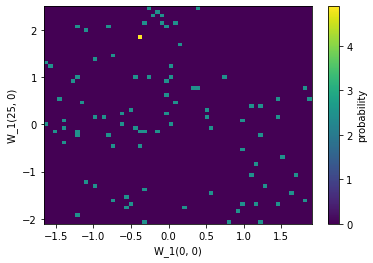

In [16]:
# try to show the correlation of two weights
print_index_1 = (0,0)
print_index_2 = (25,0)
W_print_1 = []
W_print_2 = []
for W_model in W['W_'+ str(1)][10:]:
    W_print_1.append(W_model[print_index_1])
    W_print_2.append(W_model[print_index_2])
plt.hist2d(W_print_1, W_print_2, bins=60, density=True)
plt.xlabel(f'W_1{print_index_1}')
plt.ylabel(f'W_1{print_index_2}')
cbar = plt.colorbar()
cbar.ax.set_ylabel('probability')
plt.savefig('correlation-sin-2.png')

# 2-layer DGPs (MCEM with Moving Windows)

In [5]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=2, n_rf=100, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=True),
                          kernel_type_list=['RBF' for i in range(2)], kernel_trainable=True,
                          random_fixed=True, input_cat=False)

In [6]:
model.Omega_hyperparams

2022-08-25 09:07:09.149112: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [7]:
# EM sampler settings
batch_size = 47
lr_mcmc_0 = 0.01
sampler_EM = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                               lr_0=lr_mcmc_0, momentum_decay=0.95, resample_in_cycle_head=False,
                               start_sampling_epoch=1000, epochs_per_cycle=50)

# Maximizer setttings
lr_maximizer = 0.01
optimizer = optimizers.Adam(learning_rate=lr_maximizer)
maximizer = MCEM_Q_maximizer_demo(model, num_training, optimizer)

# sampler settings after fixing hyper-params
lr_fixing_hyper_0 = 0.01
sampler_fixing_hyper = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                                         lr_0=lr_fixing_hyper_0, momentum_decay=0.95, resample_in_cycle_head=False,
                                         start_sampling_epoch=1000, epochs_per_cycle=50)

In [8]:
# MCEM with Moving Windows settings and training
total_EM_steps = 300
_, _, lines, W = MCEM_windows_demo(sampler_EM, maximizer, sampler_fixing_hyper, total_EM_steps, ds_train,
                                   num_samples_fixing_hyper=200,
                                   window_size=100, 
                                   print_epoch_cycle_EM=100, print_epoch_cycle_fixing=100)

############### EM step 1 of total 300 steps. E Step:  ###############


2022-08-25 09:07:12.154415: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-25 09:07:12.730517: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-25 09:07:12.730567: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Sampling Epoch: 99
Mean Log Likelihood -- train: -8.184826850891113, -- test: -30.45105743408203 
Root Mean Squared Error -- train: 0.43745797872543335, -- test: 0.7979311347007751 

Sampling Epoch: 199
Mean Log Likelihood -- train: -8.934456825256348, -- test: -26.9631290435791 
Root Mean Squared Error -- train: 0.4542709290981293, -- test: 0.7529512047767639 

Sampling Epoch: 299
Mean Log Likelihood -- train: -7.135907173156738, -- test: -28.468067169189453 
Root Mean Squared Error -- train: 0.41278451681137085, -- test: 0.7726799845695496 

Sampling Epoch: 399
Mean Log Likelihood -- train: -7.04610013961792, -- test: -34.507301330566406 
Root Mean Squared Error -- train: 0.4106031060218811, -- test: 0.847241997718811 

Sampling Epoch: 499
Mean Log Likelihood -- train: -7.787141799926758, -- test: -31.67310333251953 
Root Mean Squared Error -- train: 0.4282706677913666, -- test: 0.8131020665168762 

Sampling Epoch: 599
Mean Log Likelihood -- train: -6.943991661071777, -- test: -30.03

2022-08-25 10:01:38.929963: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


Sampling Epoch: 399
Mean Log Likelihood -- train: -1.7818233966827393, -- test: -8.371685028076172 
Root Mean Squared Error -- train: 0.41269776225090027, -- test: 0.7796114087104797 

Sampling Epoch: 499
Mean Log Likelihood -- train: -1.7280884981155396, -- test: -8.173208236694336 
Root Mean Squared Error -- train: 0.4083530604839325, -- test: 0.771114706993103 

Sampling Epoch: 599
Mean Log Likelihood -- train: -1.9192728996276855, -- test: -8.064432144165039 
Root Mean Squared Error -- train: 0.42360854148864746, -- test: 0.7664180994033813 

Sampling Epoch: 699
Mean Log Likelihood -- train: -2.019239664077759, -- test: -7.7634687423706055 
Root Mean Squared Error -- train: 0.4313705563545227, -- test: 0.7532708644866943 

Sampling Epoch: 799
Mean Log Likelihood -- train: -1.8457934856414795, -- test: -8.353829383850098 
Root Mean Squared Error -- train: 0.41781115531921387, -- test: 0.778850793838501 

Sampling Epoch: 899
Mean Log Likelihood -- train: -2.2646067142486572, -- test:

2022-08-25 10:28:05.398716: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


Sampling Epoch: 899
Mean Log Likelihood -- train: -1.186184048652649, -- test: -5.534194469451904 
Root Mean Squared Error -- train: 0.4092443585395813, -- test: 0.7560966610908508 

Sampling Epoch: 999
Mean Log Likelihood -- train: -1.2577035427093506, -- test: -5.7005615234375 
Root Mean Squared Error -- train: 0.41728833317756653, -- test: 0.7662559151649475 

#################### Sample No.1 at Epoch 1049  lr = 6.087738091409278e-10 ####################
********************  End of Sampling  ********************
Number of sampled models: 1 
Test Log Likelihood of all sampled models: -5.904663562774658
Test Root MSE of all sampled models: 0.7785384058952332
********************************************************************** 

********************  End of E step  ********************
Number of all sampled models in window: 99 
Test Log Likelihood of all models in window: -5.177648544311523
Test Root MSE of all models in window: 0.7664563059806824

############### EM step 242 of to

2022-08-25 10:29:49.445957: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


#################### Sample No.1 at Epoch 1049  lr = 6.087738091409278e-10 ####################
********************  End of Sampling  ********************
Number of sampled models: 1 
Test Log Likelihood of all sampled models: -6.184823989868164
Test Root MSE of all sampled models: 0.8020238876342773
********************************************************************** 

********************  End of E step  ********************
Number of all sampled models in window: 99 
Test Log Likelihood of all models in window: -5.07893180847168
Test Root MSE of all models in window: 0.7663381695747375

############### EM step 247 of total 300 steps, M Step:  ###############
**********************************************************************
Q function is -1.244832992553711 averaged by 1 samples.
********************************************************************** 

############### EM step 248 of total 300 steps. E Step:  ###############
Sampling Epoch: 99
Mean Log Likelihood -- train: -1.16

In [9]:
model.Omega_hyperparams

[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.106294334>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.05896678], dtype=float32)>,
 <tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.02263656>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.1062974], dtype=float32)>]

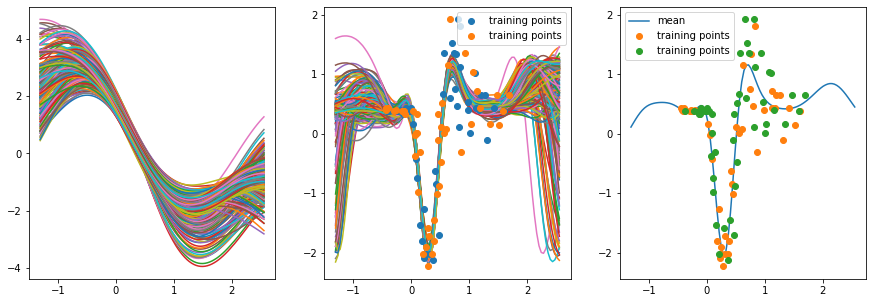

In [10]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[:]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[:]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy(), label='mean')
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()
# fig.savefig('2layer-sin.png')

index 70, X_test = 1.4218782186508179


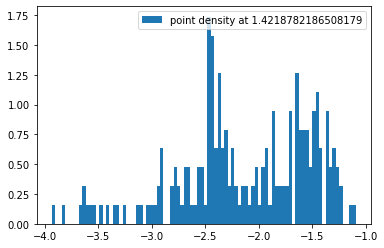

In [12]:
input_index = 70
print(f'index {input_index}, X_test = {X_test[input_index,0]}')
points = []
for model_line in lines[:]:
    line = model_line[0]
    point = line[input_index,0].numpy()
    points.append(point)
fig, ax = plt.subplots(1,1)
ax.hist(points, bins=90, density=True, label=f'point density at {X_test[input_index,0]}')
ax.legend()